In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch.utils import data
import pandas as pd
import numpy as np
#from torch.autograd import Variable, grad
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from torch.utils.data import random_split
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
realdata_path="/content/drive/My Drive/Colab Notebooks/final_1328.csv"
#data=pd.read_csv(realdata_path,index_col=0)
#data

In [ ]:
data=pd.read_csv(realdata_path,index_col=0)
X= data.drop('Diagnosis',axis=1).values
y=data['Diagnosis'].values

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
#y

In [ ]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32).unsqueeze(1)
X_val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32).unsqueeze(1)

In [ ]:
#y_val_tensor.shape
#X_train_tensor.shape


In [ ]:
class GeneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
      return len(self.X)
    def  __getitem__(self, idx):
       return self.X[idx], self.y[idx]

train_dataset=GeneDataset(X_train_tensor,y_train_tensor)
val_dataset = GeneDataset(X_val_tensor,y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
class BinaryClassifier(nn.Module):
  def __init__(self,input_dim, hidden_dim1,hidden_dim2,hidden_dim3):
    super(BinaryClassifier,self).__init__()
    self.net=nn.Sequential(
        nn.Linear(input_dim,hidden_dim1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_dim1,hidden_dim2),
        nn.ReLU(),
        nn.Linear(hidden_dim2,hidden_dim3),
        nn.ReLU(),
        nn.Linear(hidden_dim3,1),
        #nn.Sigmoid()
    )
  def forward(self,x):
    return self.net(x)




In [ ]:
input_dim=X.shape[1]
model=BinaryClassifier(input_dim,128,64,32)
#pos_weight=torch.tensor([254/50])
#neg_count=(y_train==0).sum() #IBD
#pos_count=(y_train==1).sum() #NonIBD
#total_count=len(y_train)
#pos_weight=torch.tensor([neg_count/pos_count],dtype=torch.float32)
pos_weight=torch.tensor([np.sum(y_train==0)/np.sum(y_train==1)])
criterion=torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
train_losses,val_losses,train_accs,val_accs=[],[],[],[]
num_epochs=1000

Epoch 1/1000:Train Acc=0.8872, Acc=0.7385
Epoch 2/1000:Train Acc=0.6693, Acc=0.6769
Epoch 3/1000:Train Acc=0.7160, Acc=0.7077
Epoch 4/1000:Train Acc=0.7160, Acc=0.7231
Epoch 5/1000:Train Acc=0.7432, Acc=0.7538
Epoch 6/1000:Train Acc=0.8327, Acc=0.7231
Epoch 7/1000:Train Acc=0.7510, Acc=0.7385
Epoch 8/1000:Train Acc=0.7821, Acc=0.7846
Epoch 9/1000:Train Acc=0.7899, Acc=0.6615
Epoch 10/1000:Train Acc=0.7237, Acc=0.6923
Epoch 11/1000:Train Acc=0.7899, Acc=0.7538
Epoch 12/1000:Train Acc=0.8444, Acc=0.8154
Epoch 13/1000:Train Acc=0.8288, Acc=0.7538
Epoch 14/1000:Train Acc=0.7899, Acc=0.8154
Epoch 15/1000:Train Acc=0.8521, Acc=0.8308
Epoch 16/1000:Train Acc=0.8288, Acc=0.8308
Epoch 17/1000:Train Acc=0.8677, Acc=0.8308
Epoch 18/1000:Train Acc=0.8638, Acc=0.8000
Epoch 19/1000:Train Acc=0.8444, Acc=0.8000
Epoch 20/1000:Train Acc=0.8521, Acc=0.8308
Epoch 21/1000:Train Acc=0.8872, Acc=0.8462
Epoch 22/1000:Train Acc=0.8599, Acc=0.7692
Epoch 23/1000:Train Acc=0.8716, Acc=0.8308
Epoch 24/1000:Train 

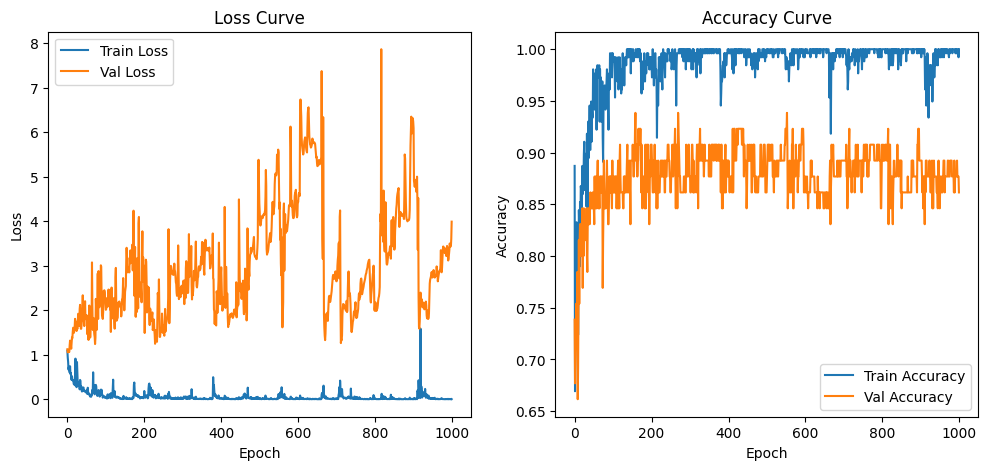

In [ ]:
for epoch in range(num_epochs):
  model.train()
  train_loss,correct, total=0.0,0.0,0.0
  for X_batch,y_batch in train_loader:
      outputs=model(X_batch)
      loss=criterion(outputs,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()
      preds=torch.sigmoid(outputs)>=0.5
      correct+=(preds==y_batch).sum().item()
      total+=y_batch.size(0)
  #train_loss/=len(train_loader)
  train_acc=correct/total

  model.eval()
  val_loss,correct,total=0.0,0.0,0.0
  with torch.no_grad():
    for X_batch,y_batch in val_loader:
      outputs=model(X_batch)
      loss=criterion(outputs,y_batch)
      val_loss+=loss.item()
      preds=torch.sigmoid(outputs)>=0.5
      correct+=(preds==y_batch).sum().item()
      total+=y_batch.size(0)

  val_acc=correct/total

  train_losses.append(train_loss/len(train_loader))
  val_losses.append(val_loss/len(val_loader))
  train_accs.append(train_acc)
  val_accs.append(val_acc)

  print(f"Epoch {epoch+1}/{num_epochs}:Train Acc={train_acc:.4f}, Acc={val_acc:.4f}")
  #print(f"\n Train Accuracy:{train_accs[-1]:.4f}")
  #print(f"\n Validation Accuracy:{val_accs[-1]:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train Accuracy')
plt.plot(val_accs,label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()



In [ ]:
all_preds=[]
all_probs=[]
all_targets=[]

for X_batch,y_batch in val_loader:
    outputs= model(X_batch)
    probs=torch.sigmoid(outputs).detach().cpu().numpy()
    preds=(probs>=0.5).astype(int)
    all_preds.extend(preds.flatten())
    all_probs.extend(probs.flatten())
    all_targets.extend(y_batch.cpu().numpy().flatten())


val_acc=accuracy_score(all_targets,all_preds)
val_prec= precision_score(all_targets,all_preds)
val_auc=roc_auc_score(all_targets,all_probs)

tn,fp,fn,tp=confusion_matrix(all_targets,all_preds).ravel()
val_spec=tn/(tn+fp)

val_losses.append(val_loss/len(val_loader))
val_accs.append(val_acc)

print(f"Epoch {epoch+1}/{num_epochs}: Acc={val_acc:.4f},Precision={val_prec:.4f},AUC={val_auc:.4f},Specificity={val_spec:.4f}")
print(f" correctly predicted IBD: {tp}, incorrectly predicted IBD: {fp}")
print(f" correctly predicted non-IBD: {tn}, incorrectly predicted non-IBD: {fn}")

Epoch 1000/1000: Acc=0.8615,Precision=0.6154,AUC=0.9245,Specificity=0.9057
 correctly predicted IBD: 8, incorrectly predicted IBD: 5
 correctly predicted non-IBD: 48, incorrectly predicted non-IBD: 4
